In [27]:
import json
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
import scipy
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
%matplotlib inline

hospitales =json.load(open("SoloHospitales.json"))


def degreesToRadians(degrees):
  return degrees * math.pi / 180


#https://rbrundritt.wordpress.com/2008/10/14/conversion-between-spherical-and-cartesian-coordinates-systems/
def gps_to_cartesians(pos):
    earthRadiusKm = 6371
    x = earthRadiusKm * math.cos(degreesToRadians(pos[1])) * math.cos(degreesToRadians(pos[0]))
    y = earthRadiusKm * math.cos(degreesToRadians(pos[1])) * math.sin(degreesToRadians(pos[0]))
    z = earthRadiusKm * math.sin(degreesToRadians(pos[1]))
    return [x,y,z]

   
plt.style.use('ggplot')
data={"id":[],"nombre":[],"latitud":[],"longitud":[],"cartesianas":[],"cartesianas_norm":[],"cartesianas_std":[]}

for i in range(0,len(hospitales)):
    data["id"].append(i)
    data["nombre"].append(hospitales[i]["nombre"])
    data["latitud"].append(hospitales[i]["coordenadas"][0])
    data["longitud"].append(hospitales[i]["coordenadas"][1])
    data["cartesianas"].append(gps_to_cartesians(hospitales[i]["coordenadas"]))

cartesians = []
for i in data['cartesianas']:
    for j in i:
        cartesians.append(j)

def min_max(l):
    l_min = min(l)
    l_max = max(l)
    return [(i - l_min) / (l_max - l_min) for i in l]

cartesianas_norm = min_max(cartesians)
cartesianas_norm = np.array(cartesianas_norm).reshape(len(cartesianas_norm)//3,3)
cartesians = np.array(cartesians).reshape(len(cartesians)//3,3)
cartesianas_std = normalize(cartesians, axis =1)
for i in cartesianas_norm:
    data["cartesianas_norm"].append(i)
for i in cartesianas_std:
    data["cartesianas_std"].append(i)    
df = pd.DataFrame(data,columns=["id","nombre","latitud","longitud","cartesianas","cartesianas_norm","cartesianas_std"])  



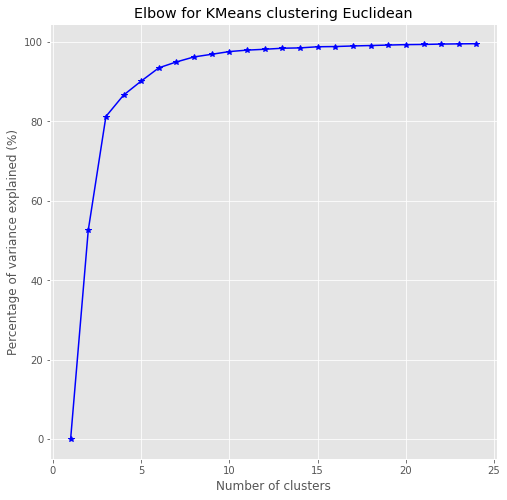

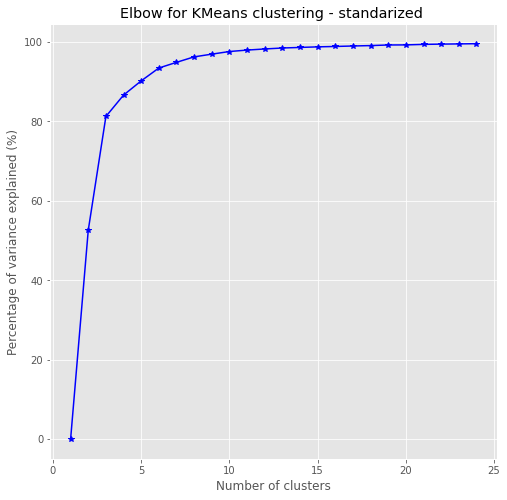

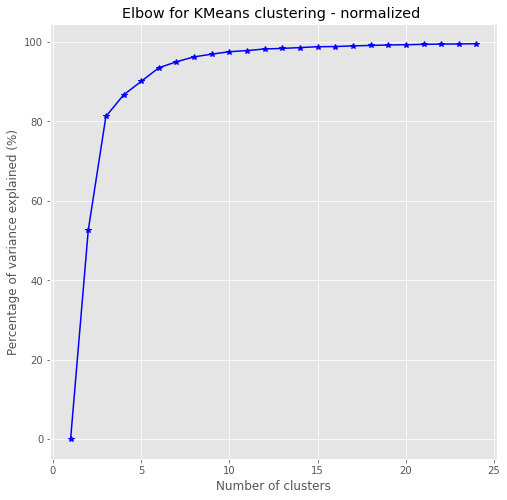

In [28]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center) for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering Euclidean')
    plt.show()
    
def plot_elbow_normalized(kmean, X,name):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center) for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering - %s ' %name)
    plt.show()    

Ks = range(1, 25)
X = cartesians
X_std = cartesianas_norm
X_norm = cartesianas_norm
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]
kmean_std = [KMeans(n_clusters=i).fit(X_std) for i in Ks]
kmean_norm = [KMeans(n_clusters=i).fit(X_norm) for i in Ks]

for k in range(3,10):
    est = kmean[k-1]
    est_std = kmean_std[k-1]
    est_norm = kmean_norm[k-1]

    df['cluster_%d' %k] = est.predict(X).tolist()
    tcenters =   est.cluster_centers_
    centers = []
    for p in df['cluster_%d' %k]:
        centers.append(tcenters[p])    
    df['centers_%d' %k] = centers
    
    df['cluster_std_%d' %k] = est_norm.predict(X_std).tolist()
    tcenters_std =   est_std.cluster_centers_
    centers_std = []    
    for p in df['cluster_std_%d' %k]:
        centers_std.append(tcenters_std[p])
    df['centers_std_%d' %k] = centers
        
    df['cluster_norm_%d' %k] = est_norm.predict(X_norm).tolist()
    tcenters_norm =   est_norm.cluster_centers_
    centers_norm  = []    
    for p in df['cluster_std_%d' %k]:
        centers_norm.append(tcenters_std[p])    
    df['centers_norm_%d' %k] = centers  

    
    
    


plot_elbow(kmean, X)
plot_elbow_normalized(kmean_std,X_std,"standarized")
plot_elbow_normalized(kmean_norm,X_norm,"normalized")


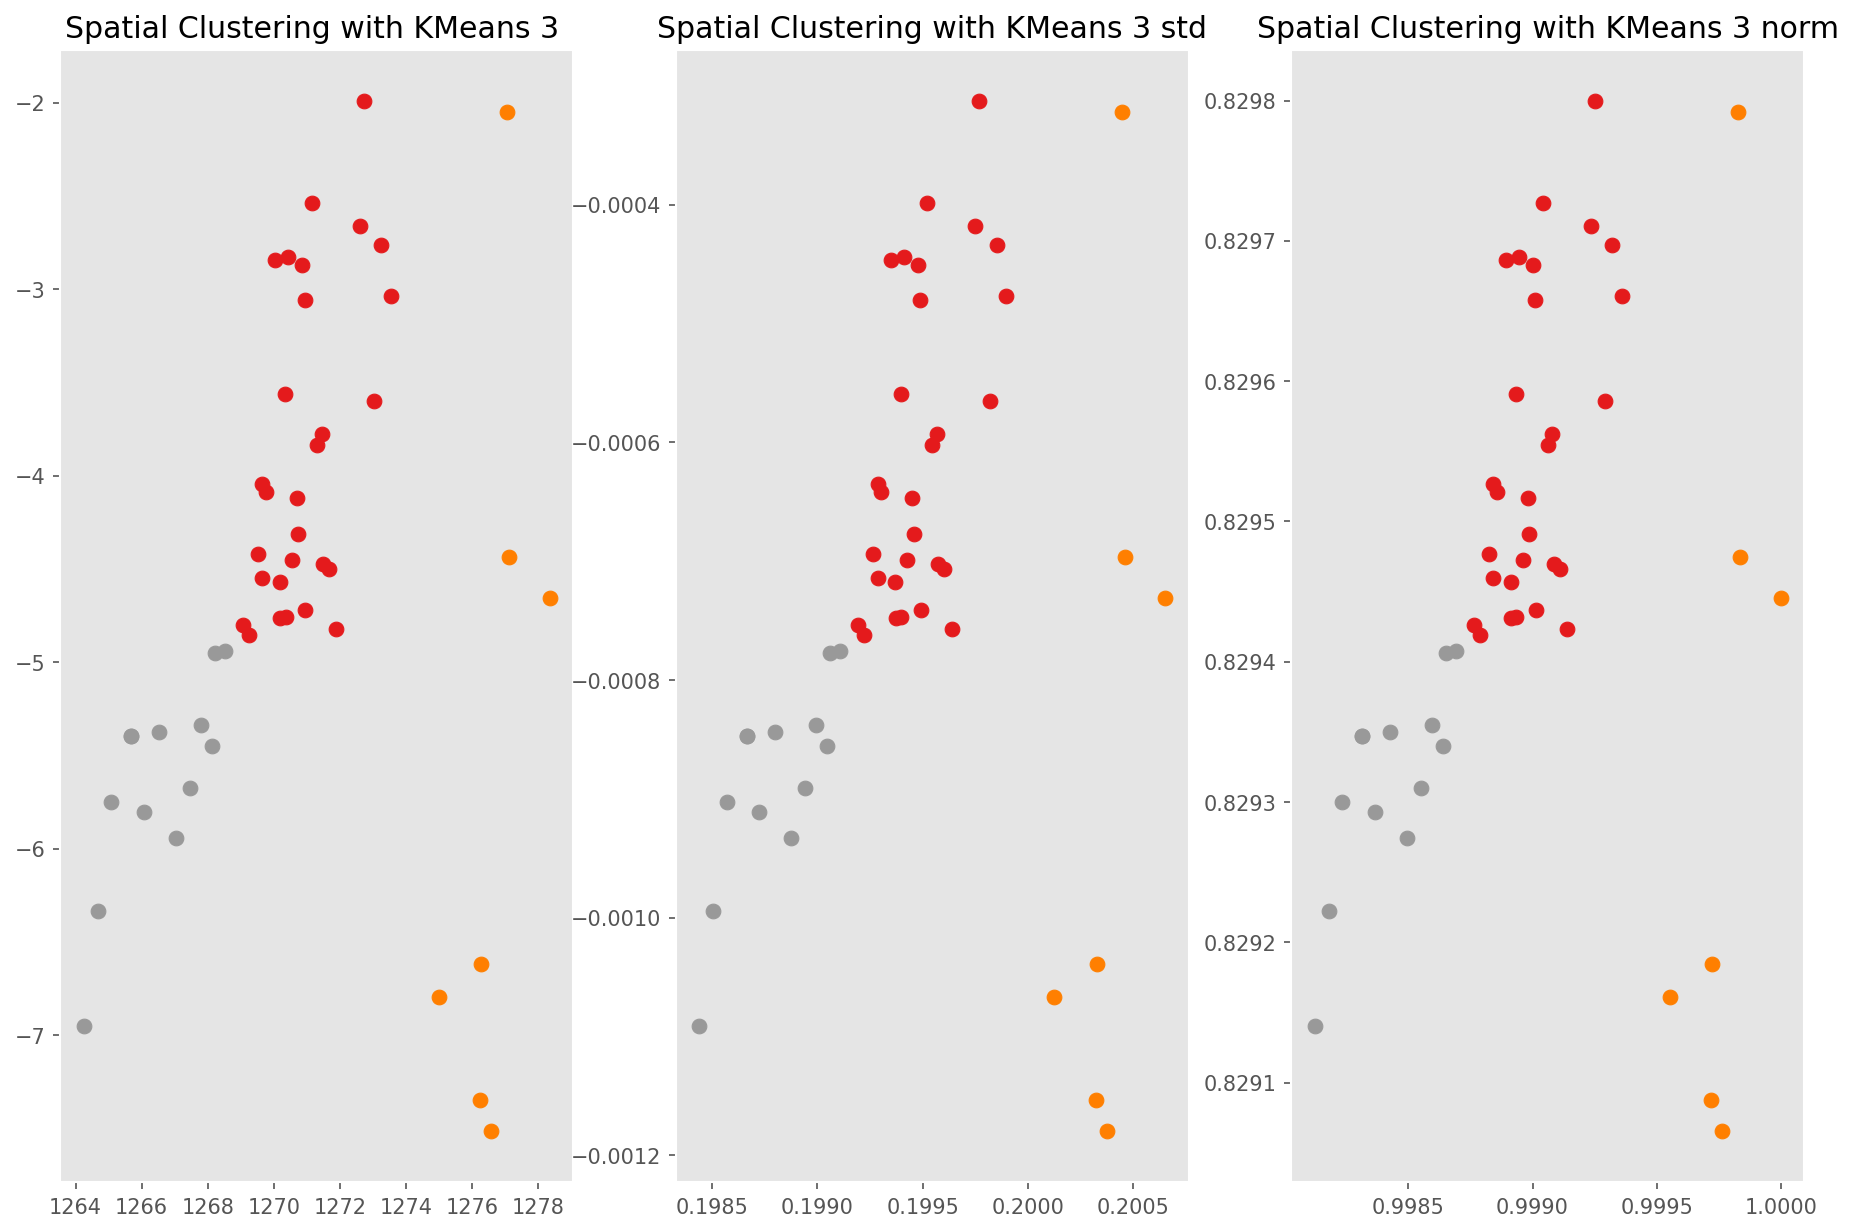

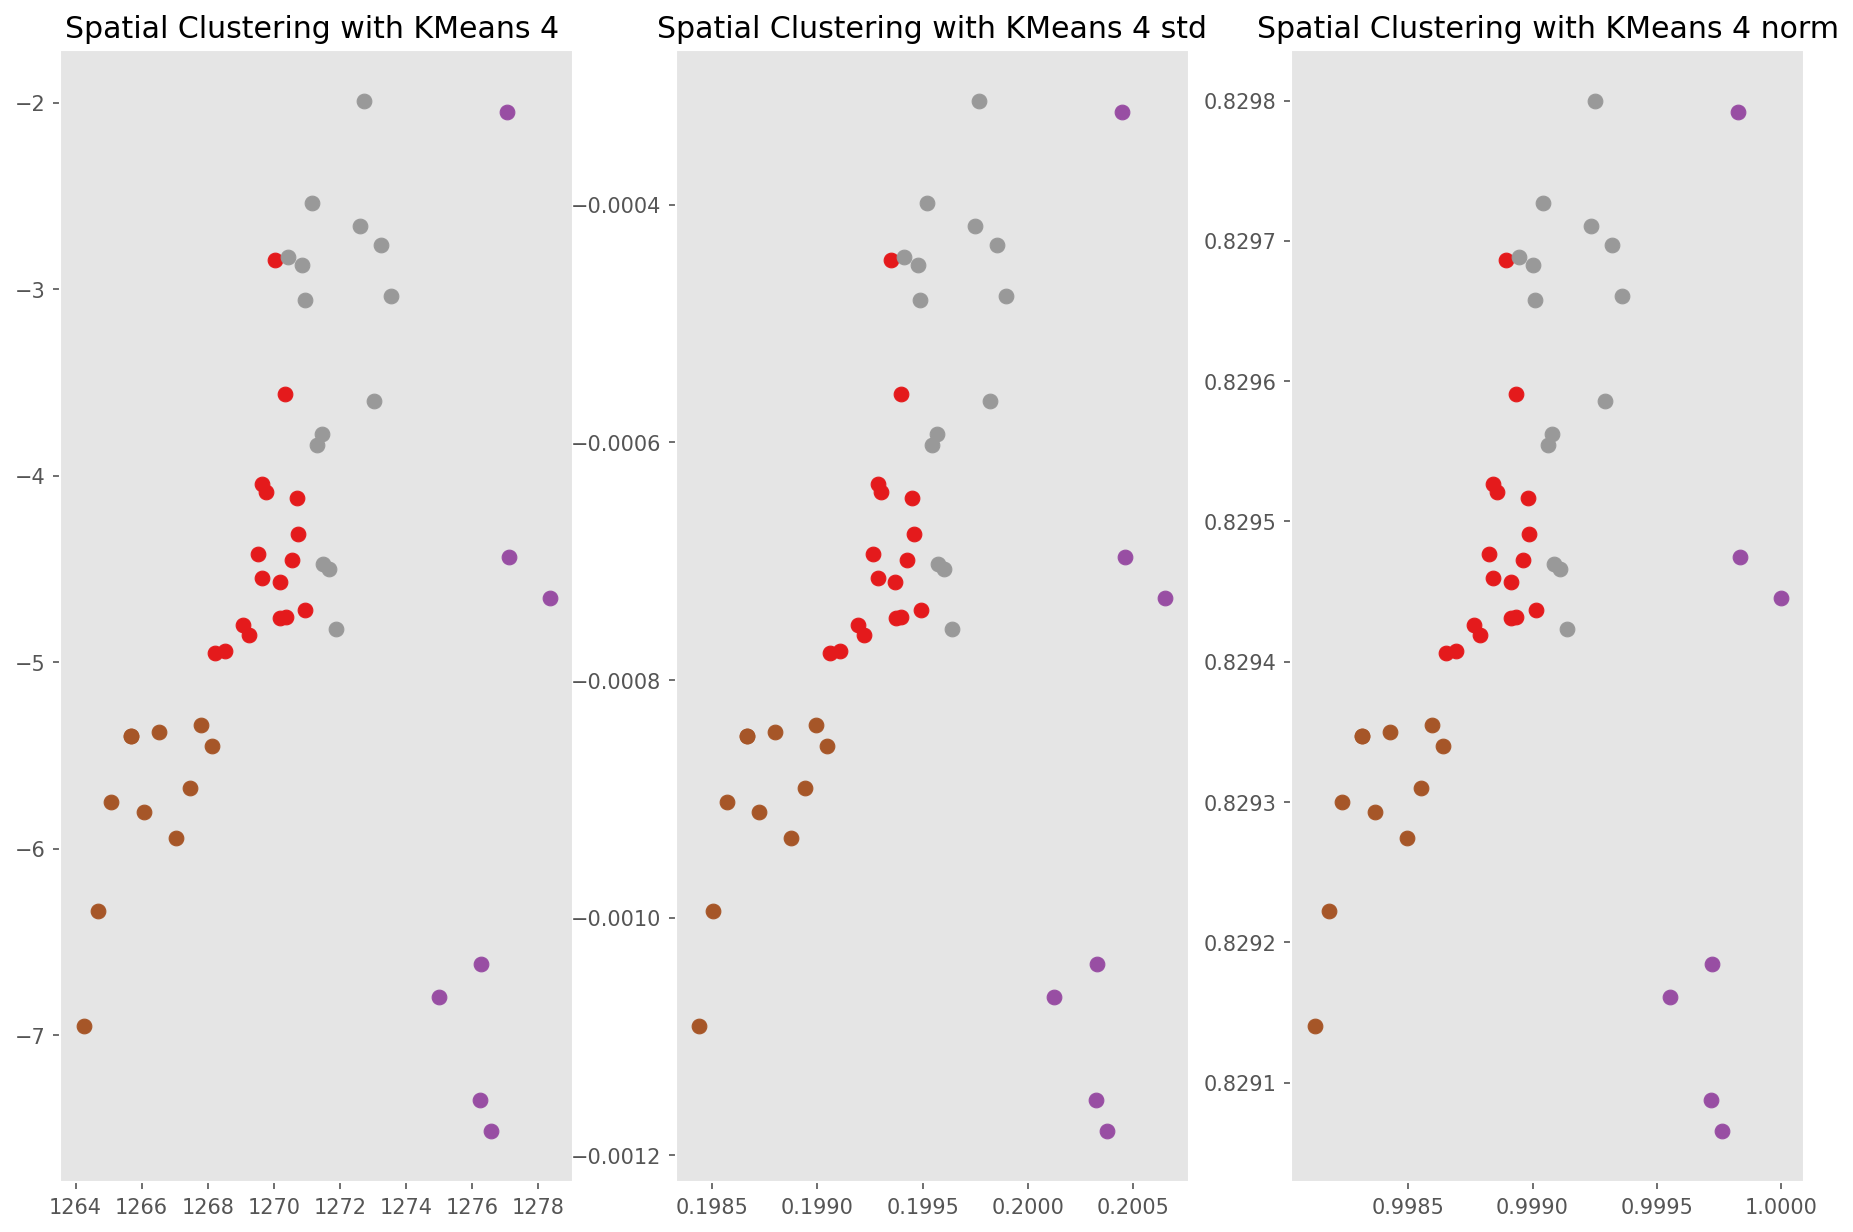

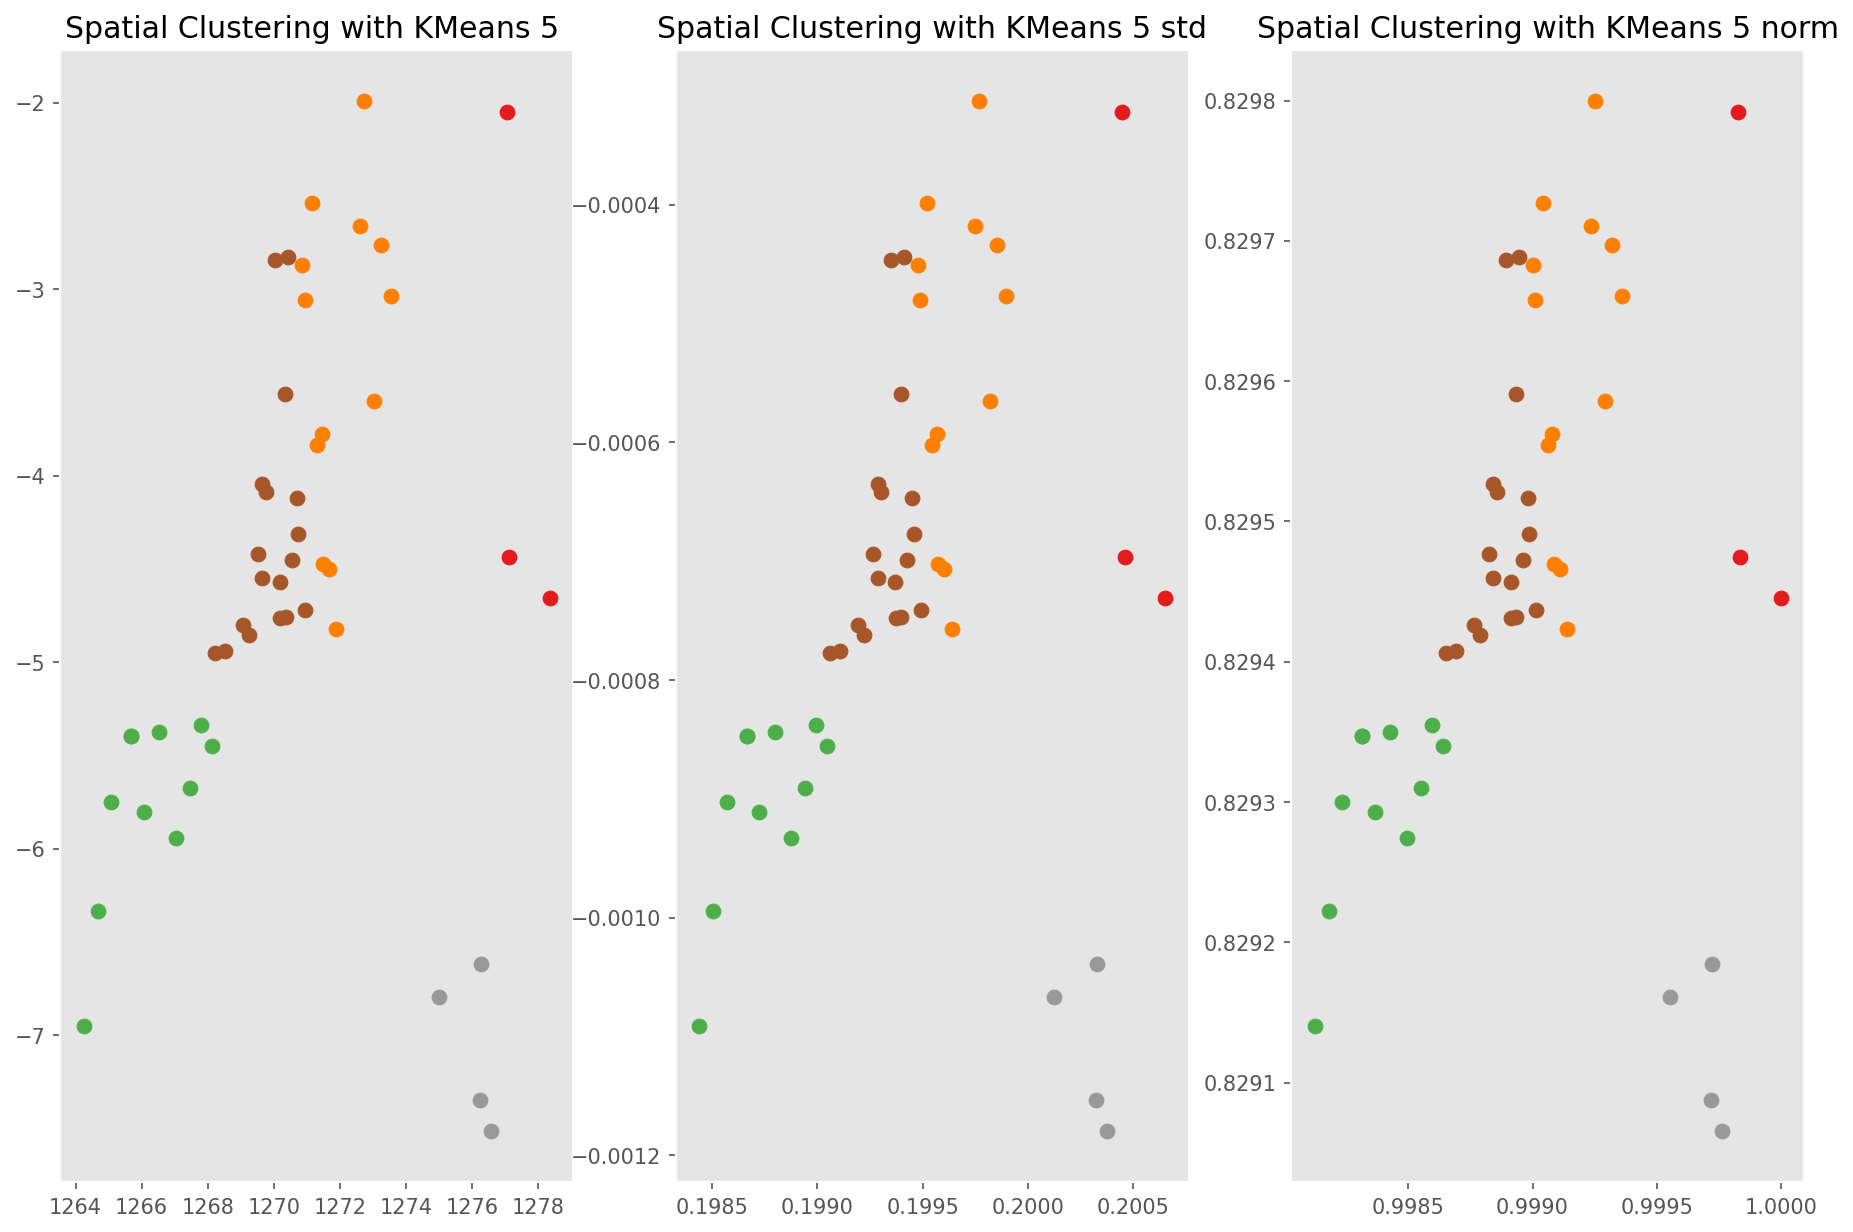

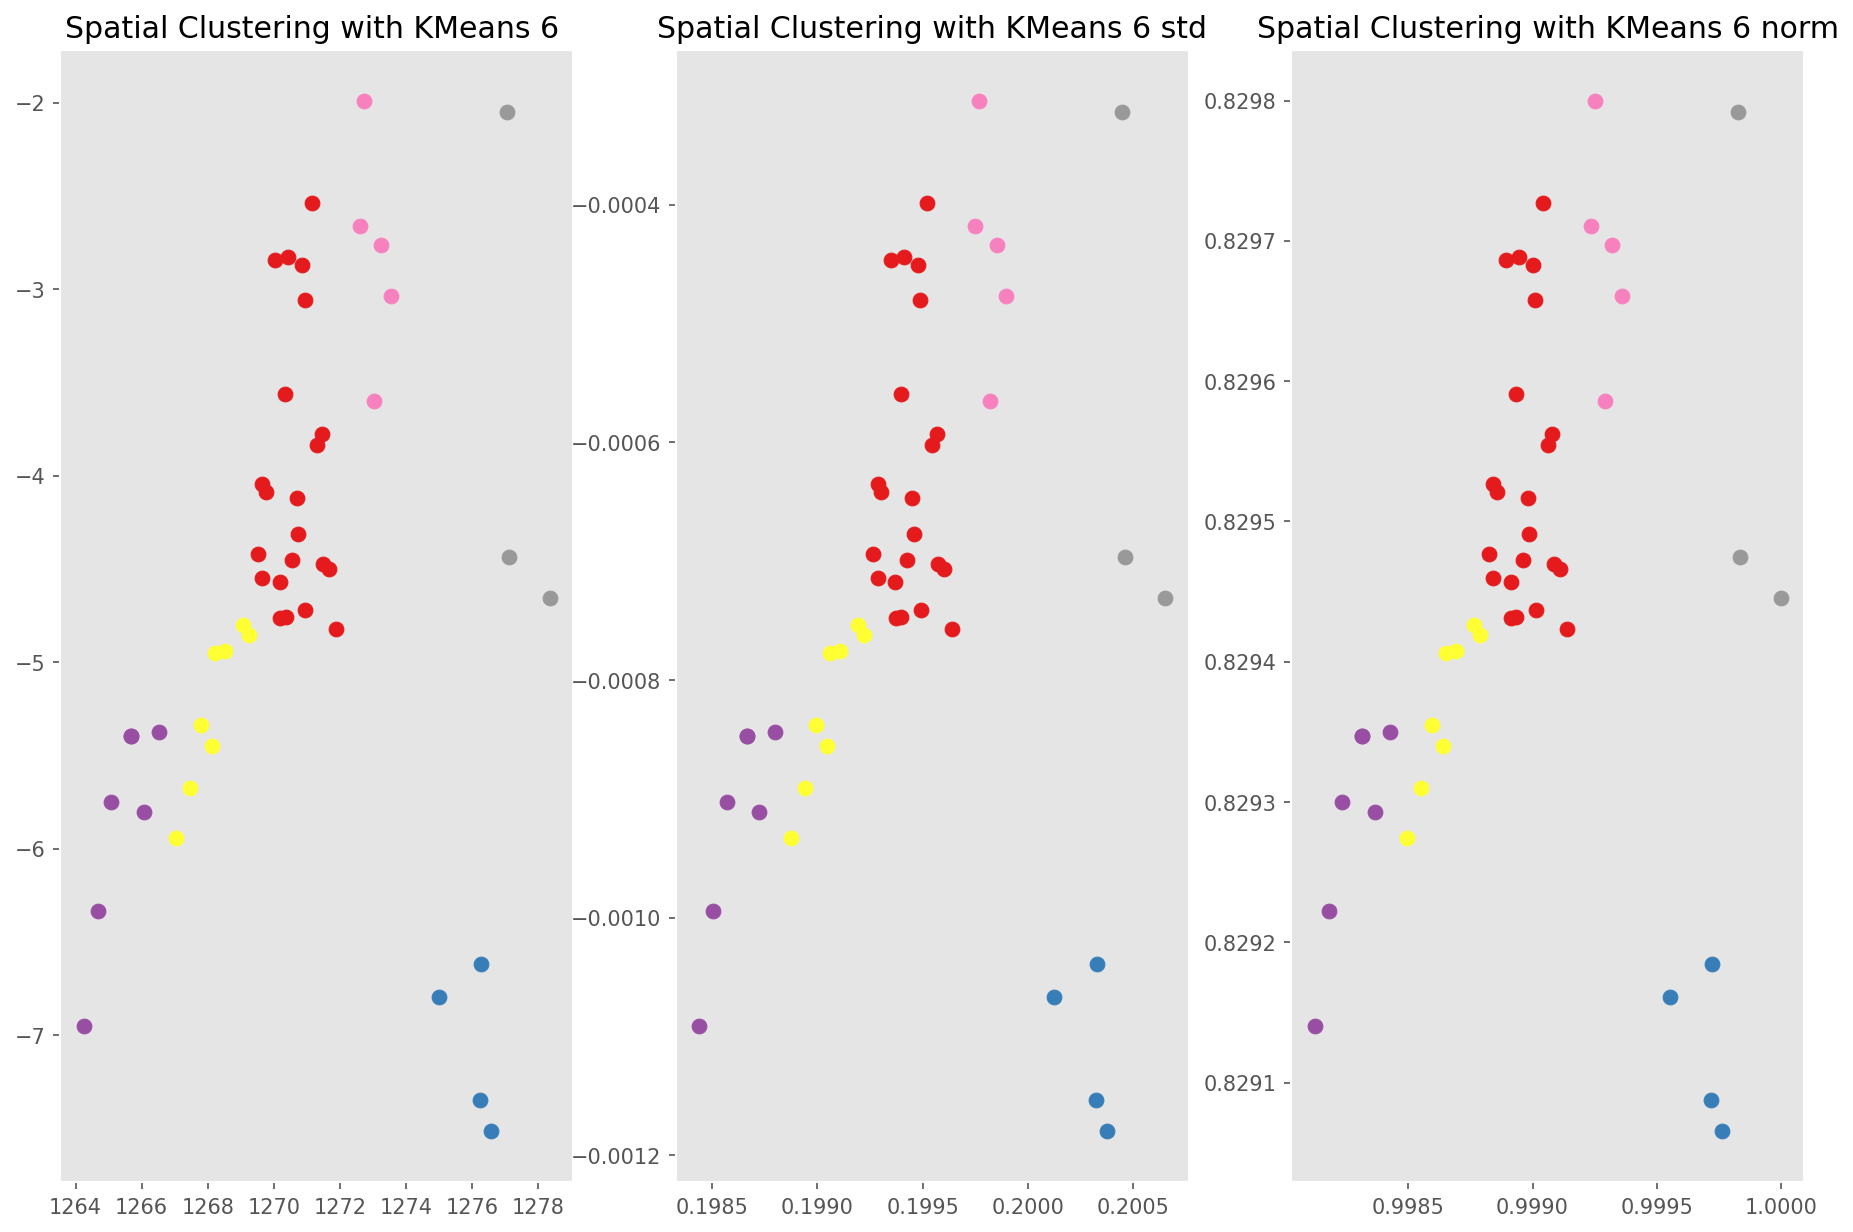

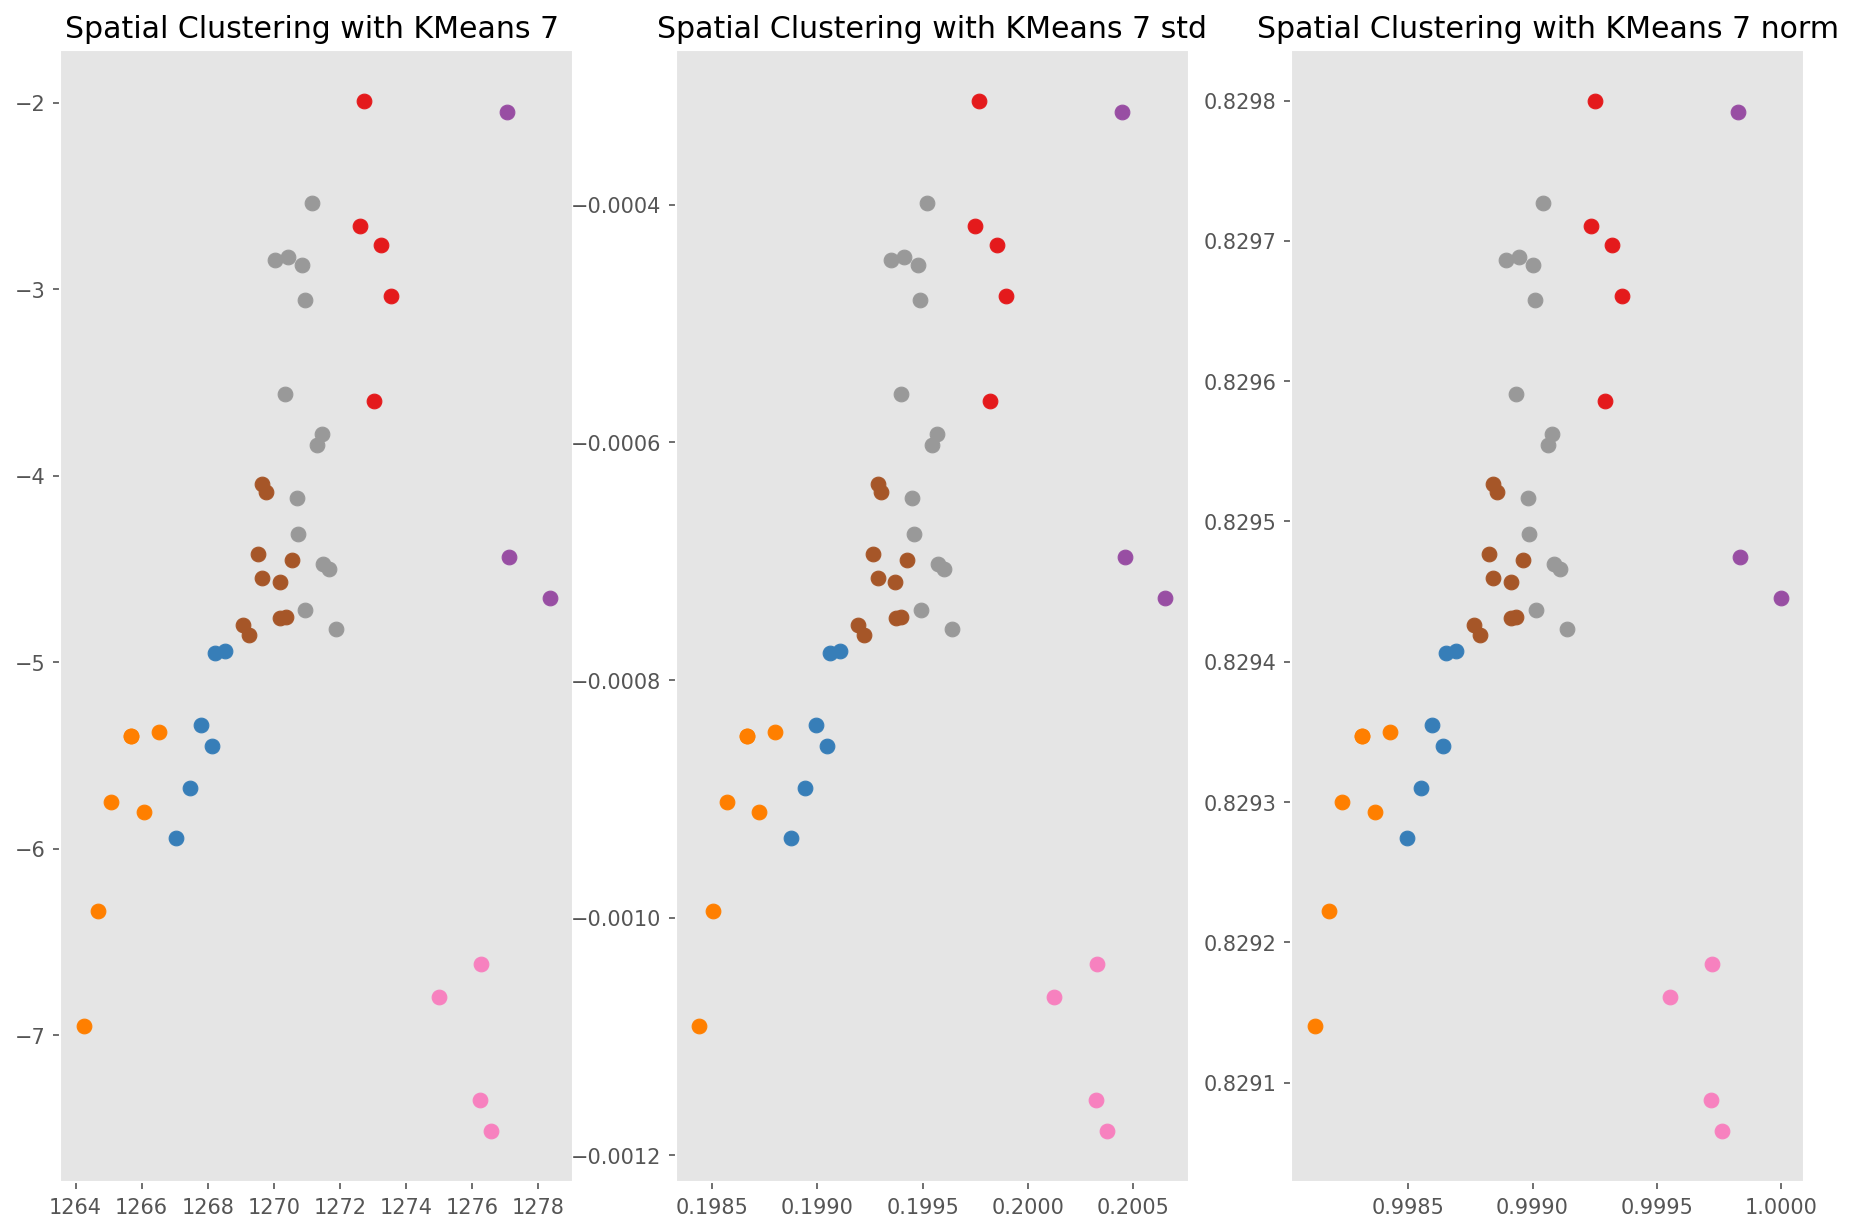

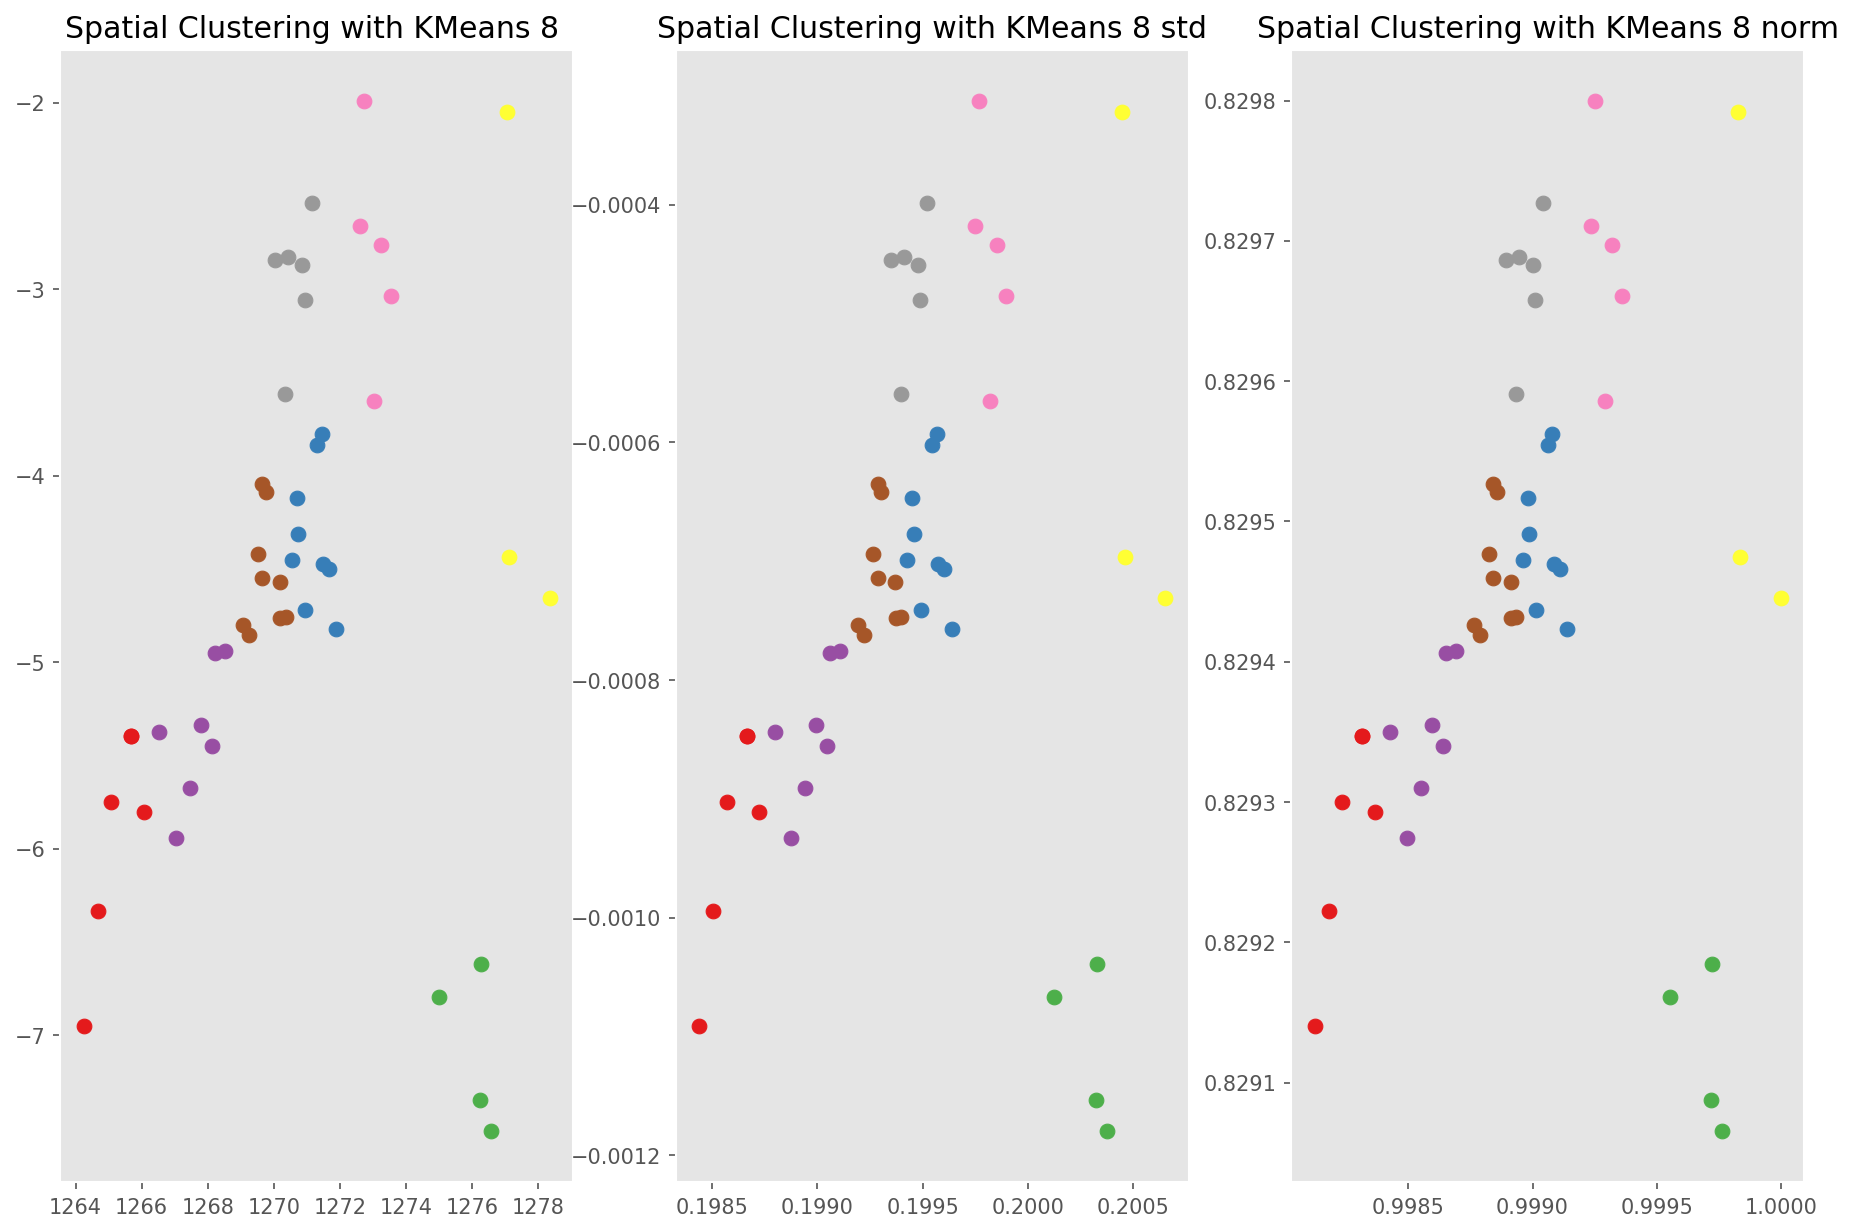

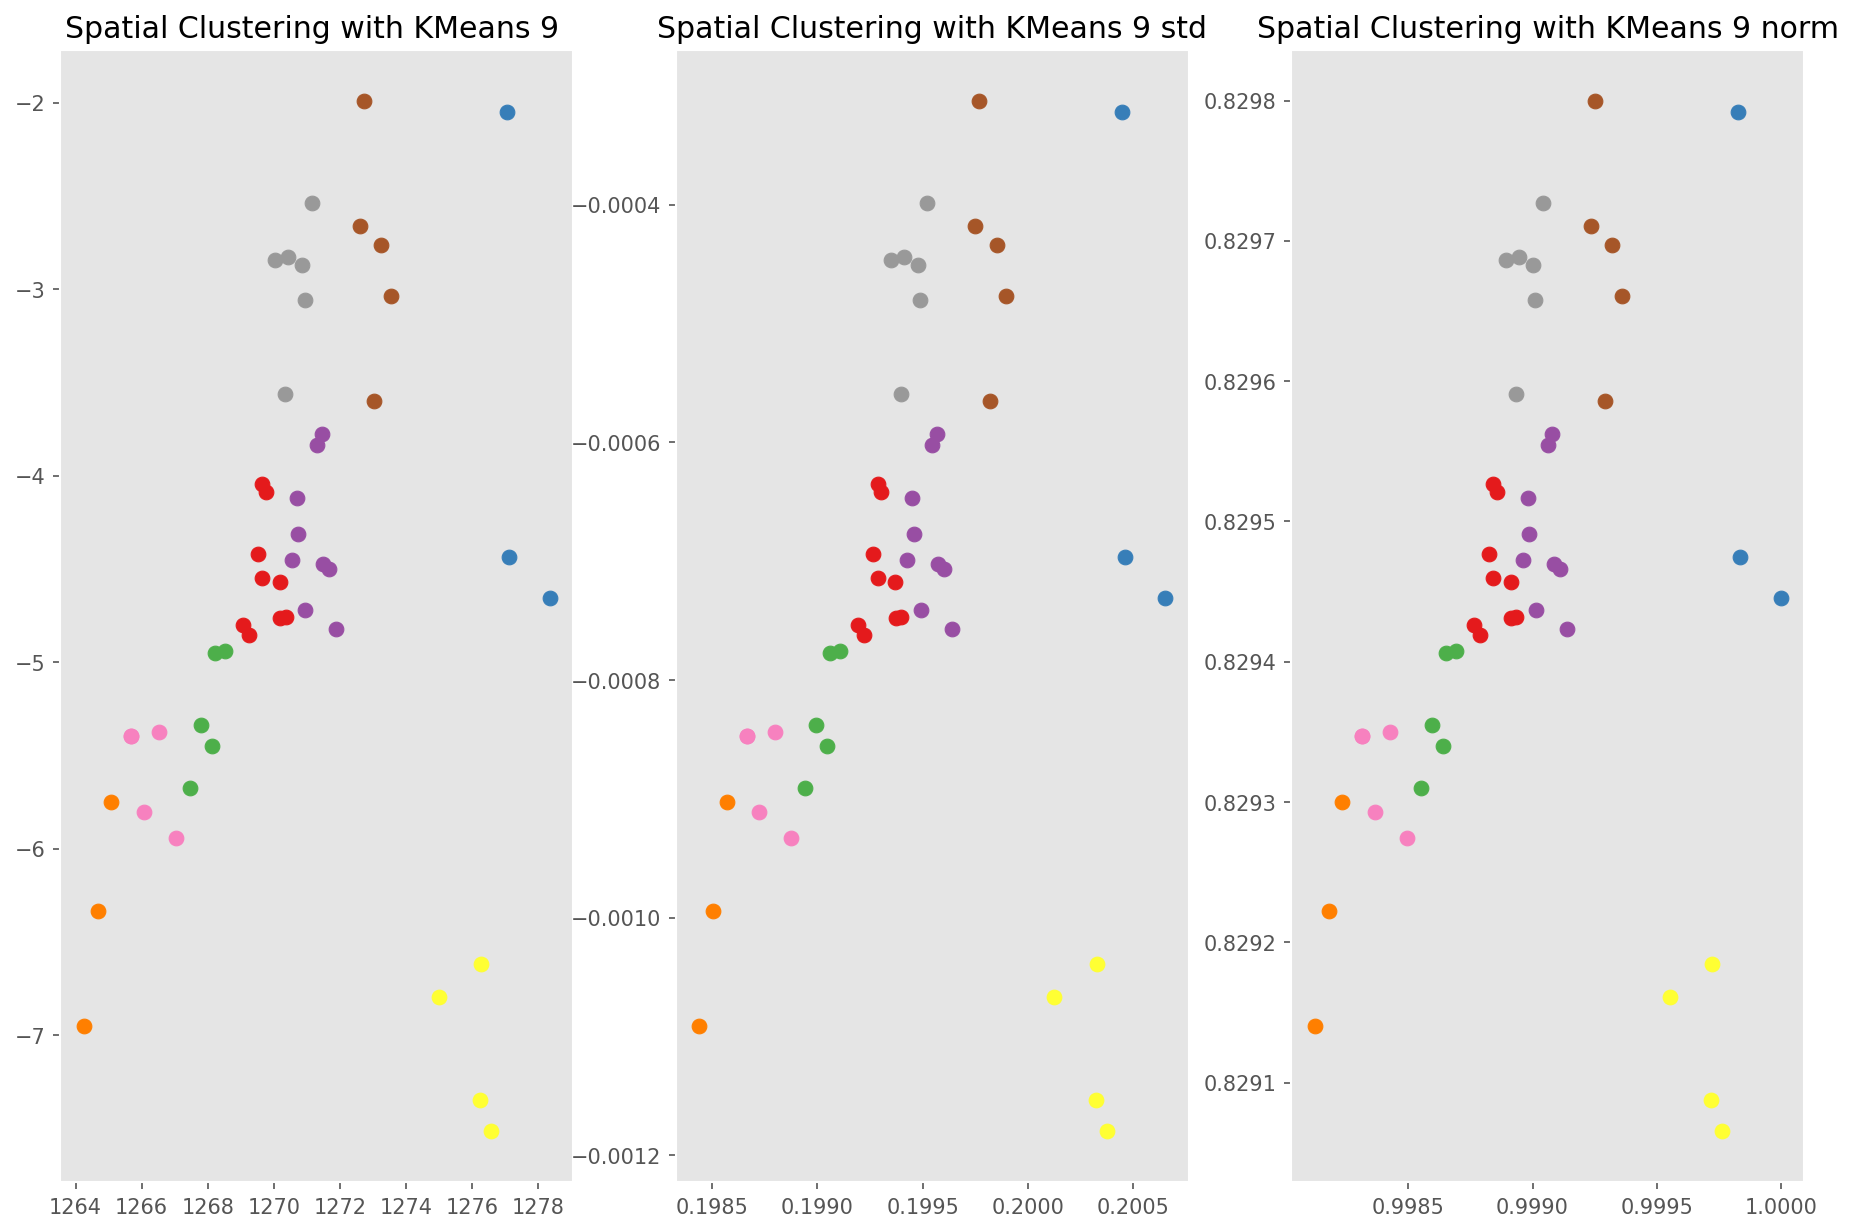

In [29]:
def plot_stations_individuals(stns,n,name):
    # determine range to print based on min, max lat and lon of the data
    colors = iter(cm.Set1(np.linspace(0, 1, n)))
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)   
    ax1.set_title("Spatial Clustering with KMeans %d " %n)
    ax1.grid(False)
    ax2.set_title("Spatial Clustering with KMeans %d std" %n)
    ax2.grid(False)
    ax3.set_title("Spatial Clustering with KMeans %d norm" %n)
    ax3.grid(False)
    #0->x, 1->y, 2->z
    v = 0
    q = 1
    for t in range(0,n):        
        df = stns.loc[stns[name] == t]
        x = [i[v] for i in df['cartesianas']]
        y = [i[q] for i in df['cartesianas']]
        x_std = [i[v] for i in df['cartesianas_std']]
        y_std = [i[q] for i in df['cartesianas_std']]        
        x_norm = [i[v] for i in df['cartesianas_norm']]
        y_norm = [i[q] for i in df['cartesianas_norm']]                
        color = next(colors)
        ax1.scatter(x,y, color=color,marker = 'o', zorder=2, alpha=1.0, s=50) 
        ax2.scatter(x_std,y_std, color=color,marker = 'o', zorder=2, alpha=1.0, s=50)
        ax3.scatter(x_norm,y_norm, color=color,marker = 'o', zorder=2, alpha=1.0, s=50)

from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = [15,10]

k = [3,4,5,6,7,8,9] #### cantidad de cluster
n = len(k)

for i in range(n):
    num = k[i]
    est = kmean[k[i]-1]
    center =  [ est.cluster_centers_[0], est.cluster_centers_[1]]
    df['cluster'] = est.predict(X).tolist()
    font = {'weight' : 'bold','size'   : 10}
    cl = len(list(df['cluster_%d' %num].unique()))
    plot_stations_individuals(df,cl,'cluster_%d' %num)  


In [13]:
df.to_csv("data_estandarizada.csv")

In [30]:
k=9
fdf=df[["id","nombre","latitud","longitud","cartesianas","cluster_%d" %k,"centers_%d" %k]]
cluster  ="cluster_%d" %k
center  ="centers_%d" %k
fdf = fdf.rename(columns = {cluster: 'cluster', center: 'center'}, inplace = False) #Cambiar nombre de columna
print(fdf)
fdf.to_json("coordenadas_con_centros.json")

    id                                             nombre   latitud  \
0    0             Hospital San Francisco de Quito (IESS) -0.089744   
1    1               Hospital General Docente de Calderón -0.092109   
2    2        Hospital Comprehensive Care for the Elderly -0.128392   
3    3                       Hospital Pablo Arturo Suarez -0.127657   
4    4                Unidad Metropolitana de Salud Norte -0.114467   
5    5                 COMMUNITY HOSPITAL SAN JOSE OBRERO -0.124464   
6    6  Specialty Center Ponceano Committee Pueblo (IESS) -0.119849   
7    7                                       NORTHOSPITAL -0.129542   
8    8                                    IESS Cotocollao -0.137769   
9    9                                     Solca Hospital -0.136678   
10  10                                    Police Hospital -0.182435   
11  11                            Hospital Vozandes Quito -0.172858   
12  12                                     Axxis Hospital -0.170256   
13  13

In [31]:
import pandas as pd
import math
df = pd.read_json('coordenadas_con_centros.json')
def calcular_distancia_euclidean(cord1,cord2):
    return math.sqrt((cord1[0]-cord2[0])**2 +(cord1[1]-cord2[1])**2+(cord1[2]-cord2[2])**2) #Calcular la distancia entre dos puntos con coordenadas cartesianas x,y,z
cl = len(list(df['cluster'].unique()))
hospital_principal=[]
for i in range(cl):
    dsc = df.loc[df['cluster'] == i]
    dsc = dsc[["id","center","cartesianas"]]
    distancia_minima=10
    hospital_centro = 0
    for index, row in dsc.iterrows():
        distancia = calcular_distancia_euclidean(row["cartesianas"],row["center"])
        if distancia_minima > distancia:
            distancia_minima = distancia
            hospital_centro=row["id"]
    hospital_principal.append(hospital_centro)

hospitales_centros = []
for p in range(0,len(df)):
    hospitales_centros.append(hospital_principal[df["cluster"][p]])    
df['hospitales_centros'] = hospitales_centros
del(df["center"])
df.to_json("coordenadas_hospitales_centroides.json")